Installing the required packages:

In [28]:
!pip install astropy

In [29]:
!pip install sep

Importing the required modules

In [30]:
import numpy as np
import sep

from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Ellipse

Loading the fits image into a 2d numpy array using .open and .data

Plotting the numpy array using imshow

Saving the loaded image as a .png

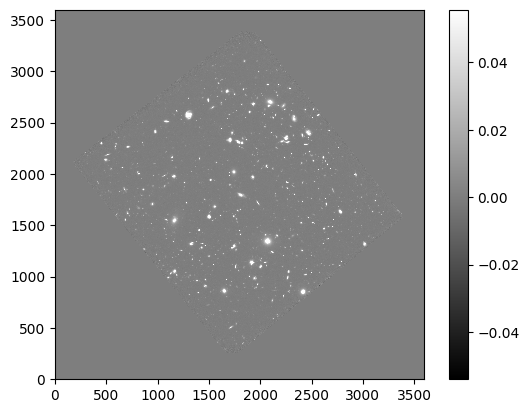

In [31]:
# Load the FITS file
fits_file = '/content/hlsp_hudf12_hst_wfc3ir_udfmain_f105w_v1.0_drz.fits'  # Replace with your file path
hdul = fits.open(fits_file)
data = hdul[0].data

# show the image
m, s = np.mean(data), np.std(data)
plt.imshow(data, interpolation='nearest', cmap='gray', vmin=m-s, vmax=m+s, origin='lower')
plt.colorbar()
plt.savefig('image.png');

Getting the background of the plotted image using the using the sep module and saving it as a .png

Printing the global mean and noise of the plotted image

0.0
0.0005398219218477607


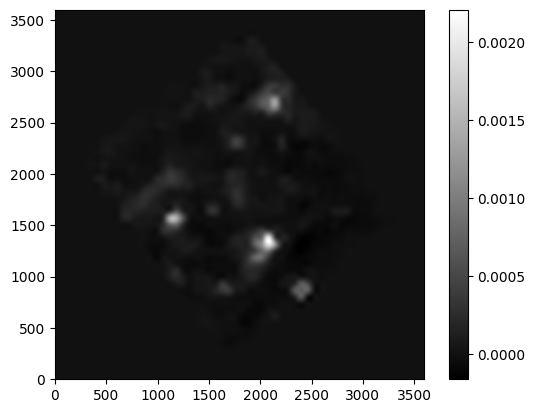

In [32]:
data = data.byteswap().newbyteorder()
# measure a spatially varying background on the image
bkg = sep.Background(data)

mask = np.zeros_like(data, dtype=bool)
bkg = sep.Background(data, mask=mask, bw=64, bh=64, fw=3, fh=3)

# get a "global" mean and noise of the image background:
print(bkg.globalback)
print(bkg.globalrms)

# evaluate background as 2-d array, same size as original image
bkg_image = bkg.back()
# bkg_image = np.array(bkg) # equivalent to above

# show the background
plt.imshow(bkg_image, interpolation='nearest', cmap='gray', origin='lower')
plt.colorbar()
plt.savefig('bckground.png');


Evaluating the background noise and plotting it onto another .png that is also saved

Subtracting the background from the main data

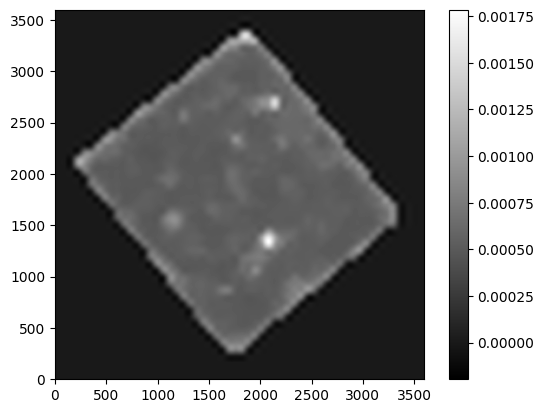

In [33]:
# evaluate the background noise as 2-d array, same size as original image
bkg_rms = bkg.rms()

# show the background noise
plt.imshow(bkg_rms, interpolation='nearest', cmap='gray', origin='lower')
plt.colorbar()
plt.savefig('noise.png');

# subtract the background
data_sub = data - bkg

Object Detection by plotting a background subtracted img

Plotting an ellipse for each detected object

Saving the img as a .png

('thresh',
 'npix',
 'tnpix',
 'xmin',
 'xmax',
 'ymin',
 'ymax',
 'x',
 'y',
 'x2',
 'y2',
 'xy',
 'errx2',
 'erry2',
 'errxy',
 'a',
 'b',
 'theta',
 'cxx',
 'cyy',
 'cxy',
 'cflux',
 'flux',
 'cpeak',
 'peak',
 'xcpeak',
 'ycpeak',
 'xpeak',
 'ypeak',
 'flag')

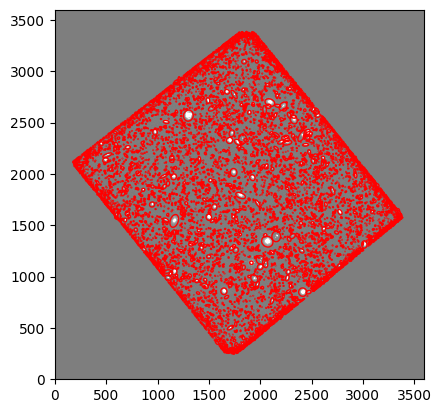

In [34]:
objects = sep.extract(data_sub, 1.5, err=bkg.globalrms)

# how many objects were detected
len(objects)

# plot background-subtracted image
fig, ax = plt.subplots()
m, s = np.mean(data_sub), np.std(data_sub)
im = ax.imshow(data_sub, interpolation='nearest', cmap='gray',
               vmin=m-s, vmax=m+s, origin='lower')

# plot an ellipse for each object
for i in range(len(objects)):
    e = Ellipse(xy=(objects['x'][i], objects['y'][i]),
                width=6*objects['a'][i],
                height=6*objects['b'][i],
                angle=objects['theta'][i] * 180. / np.pi)
    e.set_facecolor('none')
    e.set_edgecolor('red')
    ax.add_artist(e)
plt.savefig('detected.png')
# available fields
objects.dtype.names

Aperture photometry and printing the flux of all the objects found

In [35]:
flux, fluxerr, flag = sep.sum_circle(data_sub, objects['x'], objects['y'],
                                     3.0, err=bkg.globalrms, gain=1.0)

# show the first 10 objects results:
for i in range(10):
    print("object {:d}: flux = {:f} +/- {:f}".format(i, flux[i], fluxerr[i]))

object 0: flux = 0.031282 +/- 0.176890
object 1: flux = 0.031018 +/- 0.176142
object 2: flux = -0.024388 +/- 0.002883
object 3: flux = 0.001947 +/- 0.044219
object 4: flux = 0.012457 +/- 0.111649
object 5: flux = -0.011228 +/- 0.002875
object 6: flux = 0.029368 +/- 0.171394
object 7: flux = -0.009126 +/- 0.002875
object 8: flux = 0.048023 +/- 0.219161
object 9: flux = 0.027840 +/- 0.166877


Plotting a histogram of fluxes excludiong the top 1 percentile outliers

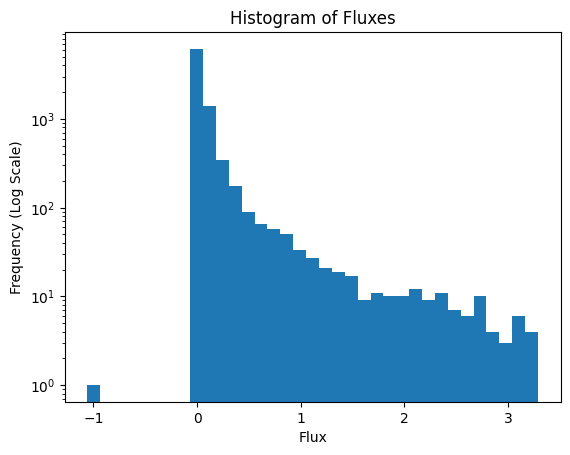

In [36]:
plt.hist(flux, bins=35, range=(np.min(flux), np.percentile(flux, 99)))  # Adjust range to exclude extreme outliers
plt.yscale('log')  # Set y-axis to log scale
plt.title('Histogram of Fluxes')
plt.xlabel('Flux')
plt.ylabel('Frequency (Log Scale)')
plt.show()



In [37]:
# Assuming 'flux' contains the flux values from your image analysis

# Calculate mean, median, and standard deviation
mean_flux = np.mean(flux)
median_flux = np.median(flux)
std_flux = np.std(flux)

# Identify the largest outlier
max_flux = np.max(flux)
outlier_index = np.argmax(flux)
outlier_position = (objects['x'][outlier_index], objects['y'][outlier_index])
outlier_deviation = (max_flux - mean_flux) / std_flux

# Print the results
print("Mean Flux:", mean_flux)
print("Median Flux:", median_flux)
print("Standard Deviation of Fluxes:", std_flux)
print("Largest Outlier Flux:", max_flux)
print("Outlier Position (x, y):", outlier_position)
print("Outlier Deviation in Standard Deviations:", outlier_deviation)


Mean Flux: 0.3617466258281149
Median Flux: 0.030954822942148894
Standard Deviation of Fluxes: 9.241925555851745
Largest Outlier Flux: 807.2972835731507
Outlier Position (x, y): (1914.2549094883857, 1134.3164850742164)
Outlier Deviation in Standard Deviations: 87.31249046216263


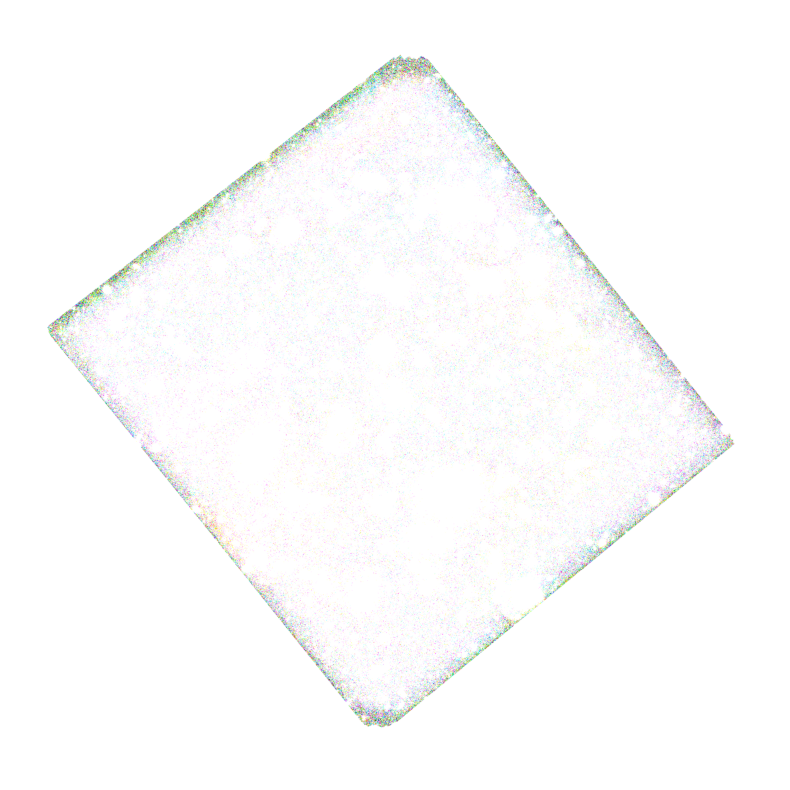

In [38]:
'''def scale_func(data):
    return np.arcsinh(data) / np.arcsinh(data.max())
'''
# Load the FITS files
f125w_data = fits.getdata('/content/hlsp_hudf12_hst_wfc3ir_udfmain_f125w_v1.0_drz.fits', ext=0)
f160w_data = fits.getdata('/content/hlsp_hudf12_hst_wfc3ir_udfmain_f160w_v1.0_drz.fits', ext=0)
f105w_data = fits.getdata('/content/hlsp_hudf12_hst_wfc3ir_udfmain_f105w_v1.0_drz.fits', ext=0)

# Define a simple linear scaling function
def scale_data(data, a=0, b=255, clip=True):
    if clip:
        data = np.clip(data, np.percentile(data, 1), np.percentile(data, 99))
    scaled_data = ((data - np.min(data)) / (np.max(data) - np.min(data)))
    return scaled_data * (b - a) + a

# Apply the scaling function to each channel
f160w_scaled = scale_data(f160w_data)
f125w_scaled = scale_data(f125w_data)
f105w_scaled = scale_data(f105w_data)

# Combine the channels into an RGB image
rgb_image = np.stack([f160w_scaled, f125w_scaled, f105w_scaled], axis=-1)

# Display the image
plt.figure(figsize=(10, 10))
plt.imshow(rgb_image, origin='lower', aspect='equal')
plt.axis('off')  # Disable axis
plt.savefig('hudf_false_color.png', bbox_inches='tight', pad_inches=0)
plt.show()
